In [1]:
# Importing the necessary files from the project folder
import helper
import model

# Importing necessary libraries such as numpy, pandas, and seaborn for data manipulation
import time
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Importing necessary classes and functions for the machine learning models
from model import LSTM_Model
from model import RLSTM_Model
from model import train_LSTM
from model import train_RLSTM

# Importing PyTorch as well as Dataloaders
import torch
from torch.utils.data import DataLoader
from torch import nn

In [2]:
# Reading the csv file into a pandas data frame and dropping certain columns
df = pd.read_csv('dataset_MRK_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0', "Close_lead1"], axis=1)

# Setting a variable with the target (closing price) and getting the remaining columns
target = "Close"
features = list(df.columns.difference([target]))

Text(0.5, 1.0, 'Correlation Heatmap')

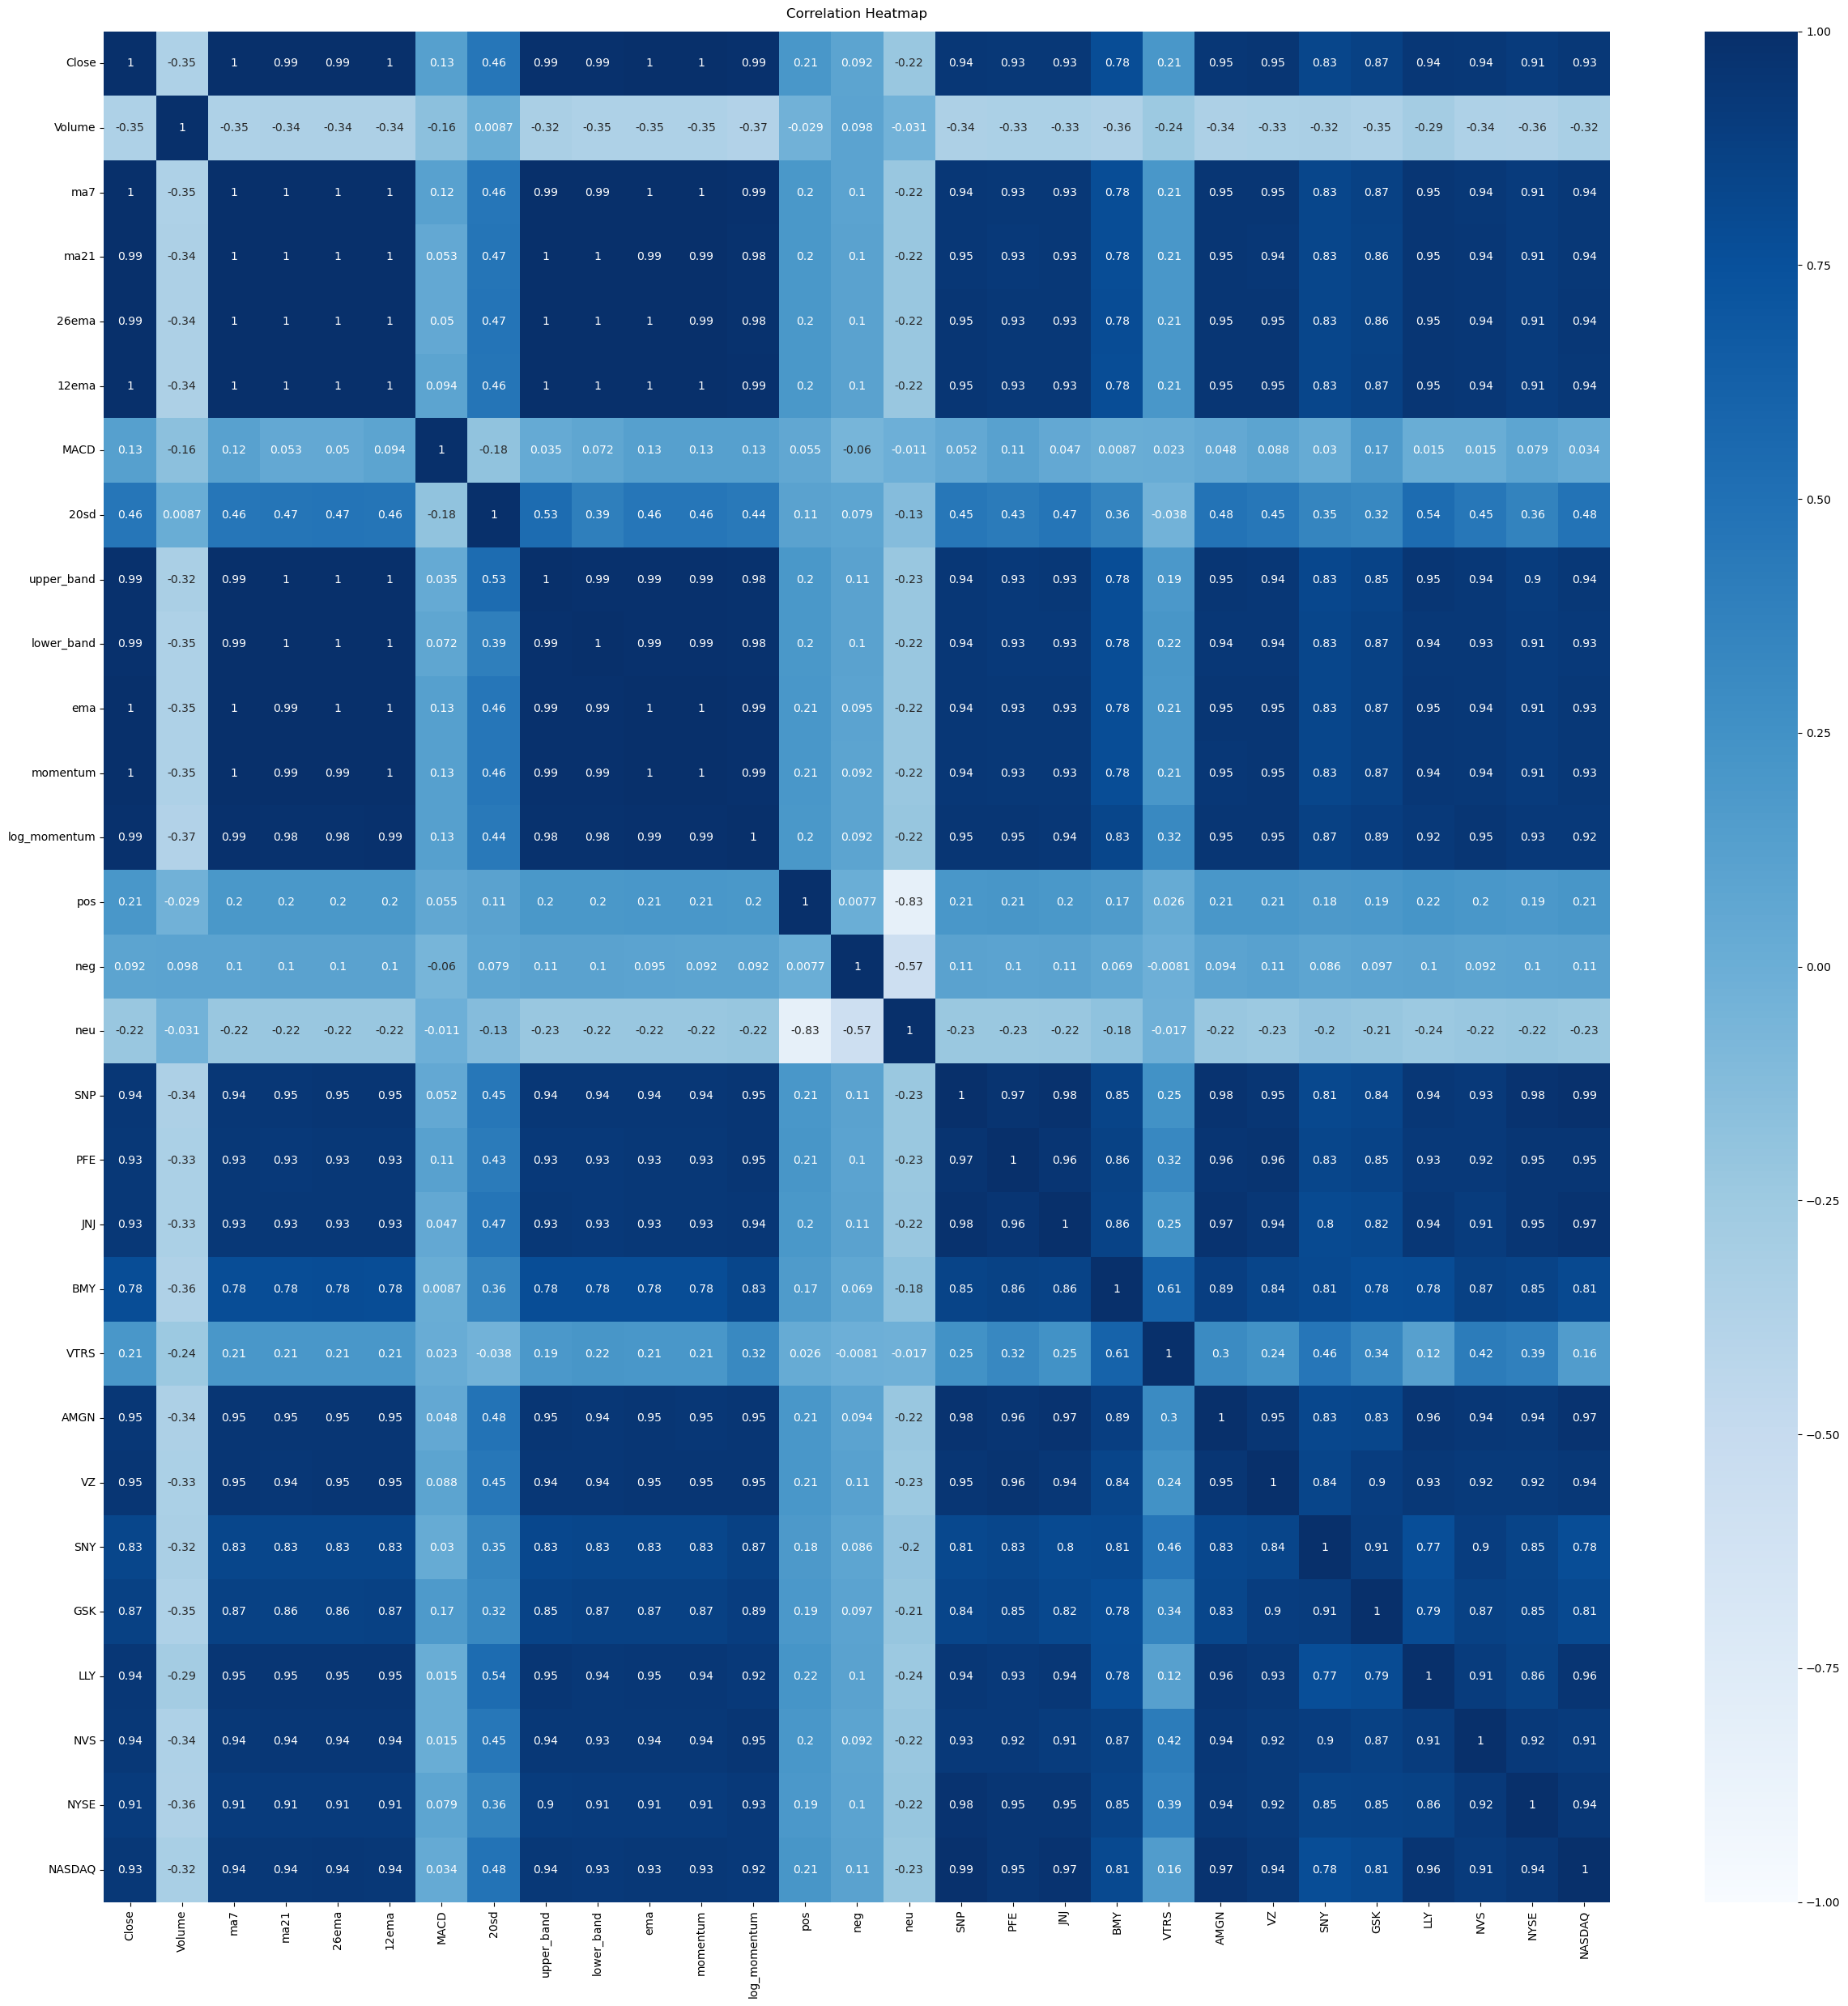

In [3]:
# Getting and plotting a correlation heat map between features to include inside of the paper
plt.figure(figsize=(30, 30))
corr = df.corr()
heatmap = sb.heatmap(corr, vmin=-1, vmax=1, cmap="Blues", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [3]:
# Splitting data into training and test data sets
size = int(len(df) * 0.75)
df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

# Standardization for easier training of the models
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()
for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()
    df_train[c] = (df_train[c] - mean)/stdev
    df_test[c] = (df_test[c] - mean)/stdev

In [4]:
# Processing data sectionm
# Setting the random seed to make results more consistent, allowing for easier debugging
torch.manual_seed(1)

# Setting variable such as batch size and sequence length for the datasets
# Using sequence dataset class from the model.py file
batch_size = 32
sequence_len = 128
train_dataset = model.SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_len
)
test_dataset = model.SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_len
)

In [6]:
# Creating iterators or dataloaders for our machine learning models
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Setting initial hyperparameters such as alpah or learning rate as well as the number of hidden units in our model
learning_rate = 0.005
num_hidden_units = 32

# Declare the models and their respective loss functions and optimizers for back porpogation
# Loss functions determine how the model is changed 
# Optimizers like Adam help make the training process become expedited 
model1 = RLSTM_Model(num_features=len(features), hidden_units=num_hidden_units, batch_size=batch_size, omega=96, num_recall=1)
loss_function1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

model2 = LSTM_Model(num_features=len(features), hidden_units=num_hidden_units)
loss_function2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# Arrays for storing the losses outputted by the model
classical_loss_train1 = []
classical_loss_train2 = []
print("Untrained test\n--------")

# For loop that trains the model for a certain number of epochs
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss1 = train_RLSTM(train_loader, model1, loss_function1, optimizer=optimizer1)
    train_loss2 = train_LSTM(train_loader, model2, loss_function2, optimizer=optimizer2)
    classical_loss_train1.append(train_loss1)
    classical_loss_train2.append(train_loss2)


Untrained test
--------
Epoch 0
---------
RLSTM Train loss: 0.8219833360053599
LSTM Train loss: 0.06549042413098505
Epoch 1
---------
RLSTM Train loss: 0.18971111724385992
LSTM Train loss: 0.004762884358569863
Epoch 2
---------
RLSTM Train loss: 0.05611146945739165
LSTM Train loss: 0.0023804752909200033
Epoch 3
---------
RLSTM Train loss: 0.032603869534796104
LSTM Train loss: 0.001785665335773956
Epoch 4
---------
RLSTM Train loss: 0.020732413773657754
LSTM Train loss: 0.0012700095376203535
Epoch 5
---------
RLSTM Train loss: 0.01526722920971224
LSTM Train loss: 0.0011236474106226524
Epoch 6
---------
RLSTM Train loss: 0.012026420692563988
LSTM Train loss: 0.000654551002980952
Epoch 7
---------
RLSTM Train loss: 0.009437902153877076
LSTM Train loss: 0.0005653419671034499
Epoch 8
---------
RLSTM Train loss: 0.008258277186541818
LSTM Train loss: 0.00043672017341123137
Epoch 9
---------
RLSTM Train loss: 0.007396107248496264
LSTM Train loss: 0.00046715475878045254


In [16]:
# Prediction functions for each of the machine learning models
# Despite being identitical, they were seperated for debugging purposes
# They are also recycled from the model.py file as they are identical to the testing functions for both the LSTM and RLSTM
def predictLSTM(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def predictRLSTM(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [17]:
# Loading the dataloader
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Getting the outputs from both models and storing them
ystar_col1 = "RLSTM forecast"
# Here the results are cut off due to the padding provided by the model
df_train[ystar_col1] = (predictRLSTM(train_eval_loader, model1).numpy())[0:2038]
df_test[ystar_col1] = (predictRLSTM(test_loader, model1).numpy())[0:680]

ystar_col2 = "LSTM forecast"
df_train[ystar_col2] = predictLSTM(train_eval_loader, model2).numpy()
df_test[ystar_col2] = predictLSTM(test_loader, model2).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col1, ystar_col2]]

# Multiplied by the standard deviation and summed with the mean to get the actual results
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

          Close  RLSTM forecast  LSTM forecast
0     31.011450       30.633301      30.823030
1     31.440840       30.822079      31.224148
2     31.183207       30.859909      31.288116
3     31.364504       32.178806      31.508799
4     30.839695       31.033569      31.199654
...         ...             ...            ...
2712  78.301529       69.117798      66.644485
2713  77.814888       69.281845      66.728958
2714  78.492363       70.665985      66.976967
2715  79.103050       70.790733      66.990753
2716  78.492363       71.902512      67.136002

[2718 rows x 3 columns]


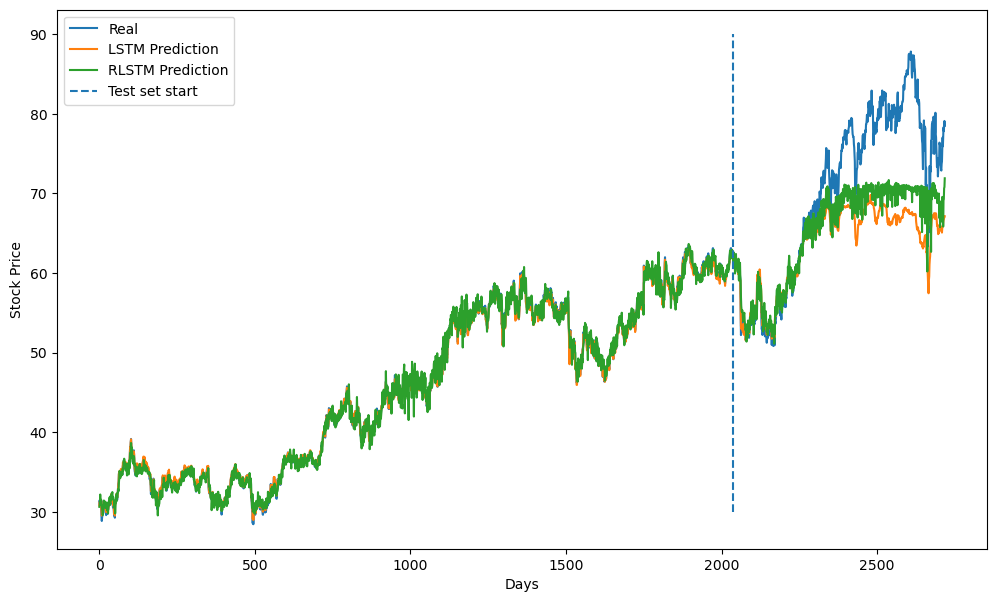

In [48]:
# Plotting the LSTM's forecase
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out["Close"], label = "Real")
plt.plot(range(2718), df_out["LSTM forecast"], label = "LSTM Prediction")
plt.plot(range(2718), df_out["RLSTM forecast"], label = "RLSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [20]:
# Viewing which sequence indices were most recalled
model1.recalled

[tensor([[42.]], grad_fn=<RoundBackward0>),
 tensor([[37.]], grad_fn=<RoundBackward0>),
 tensor([[42.]], grad_fn=<RoundBackward0>),
 tensor([[42.]], grad_fn=<RoundBackward0>),
 tensor([[38.]], grad_fn=<RoundBackward0>),
 tensor([[42.]], grad_fn=<RoundBackward0>),
 tensor([[44.]], grad_fn=<RoundBackward0>),
 tensor([[43.]], grad_fn=<RoundBackward0>),
 tensor([[41.]], grad_fn=<RoundBackward0>),
 tensor([[44.]], grad_fn=<RoundBackward0>),
 tensor([[43.]], grad_fn=<RoundBackward0>),
 tensor([[47.]], grad_fn=<RoundBackward0>),
 tensor([[47.]], grad_fn=<RoundBackward0>),
 tensor([[46.]], grad_fn=<RoundBackward0>),
 tensor([[43.]], grad_fn=<RoundBackward0>),
 tensor([[45.]], grad_fn=<RoundBackward0>),
 tensor([[48.]], grad_fn=<RoundBackward0>),
 tensor([[48.]], grad_fn=<RoundBackward0>),
 tensor([[42.]], grad_fn=<RoundBackward0>),
 tensor([[48.]], grad_fn=<RoundBackward0>),
 tensor([[48.]], grad_fn=<RoundBackward0>),
 tensor([[48.]], grad_fn=<RoundBackward0>),
 tensor([[47.]], grad_fn=<RoundB

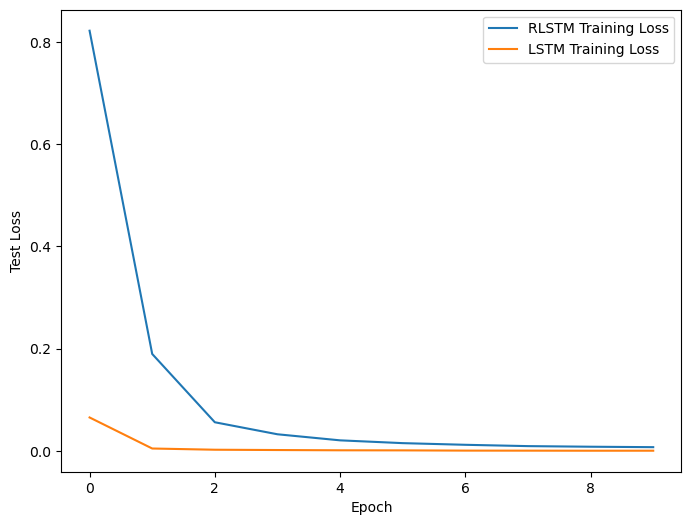

In [22]:
# Plotting the training losses for the RLSTM and LSTM
plt.figure(figsize=(8, 6))
plt.plot(classical_loss_train1, label = "RLSTM Training Loss")
plt.plot(classical_loss_train2, label = "LSTM Training Loss")
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

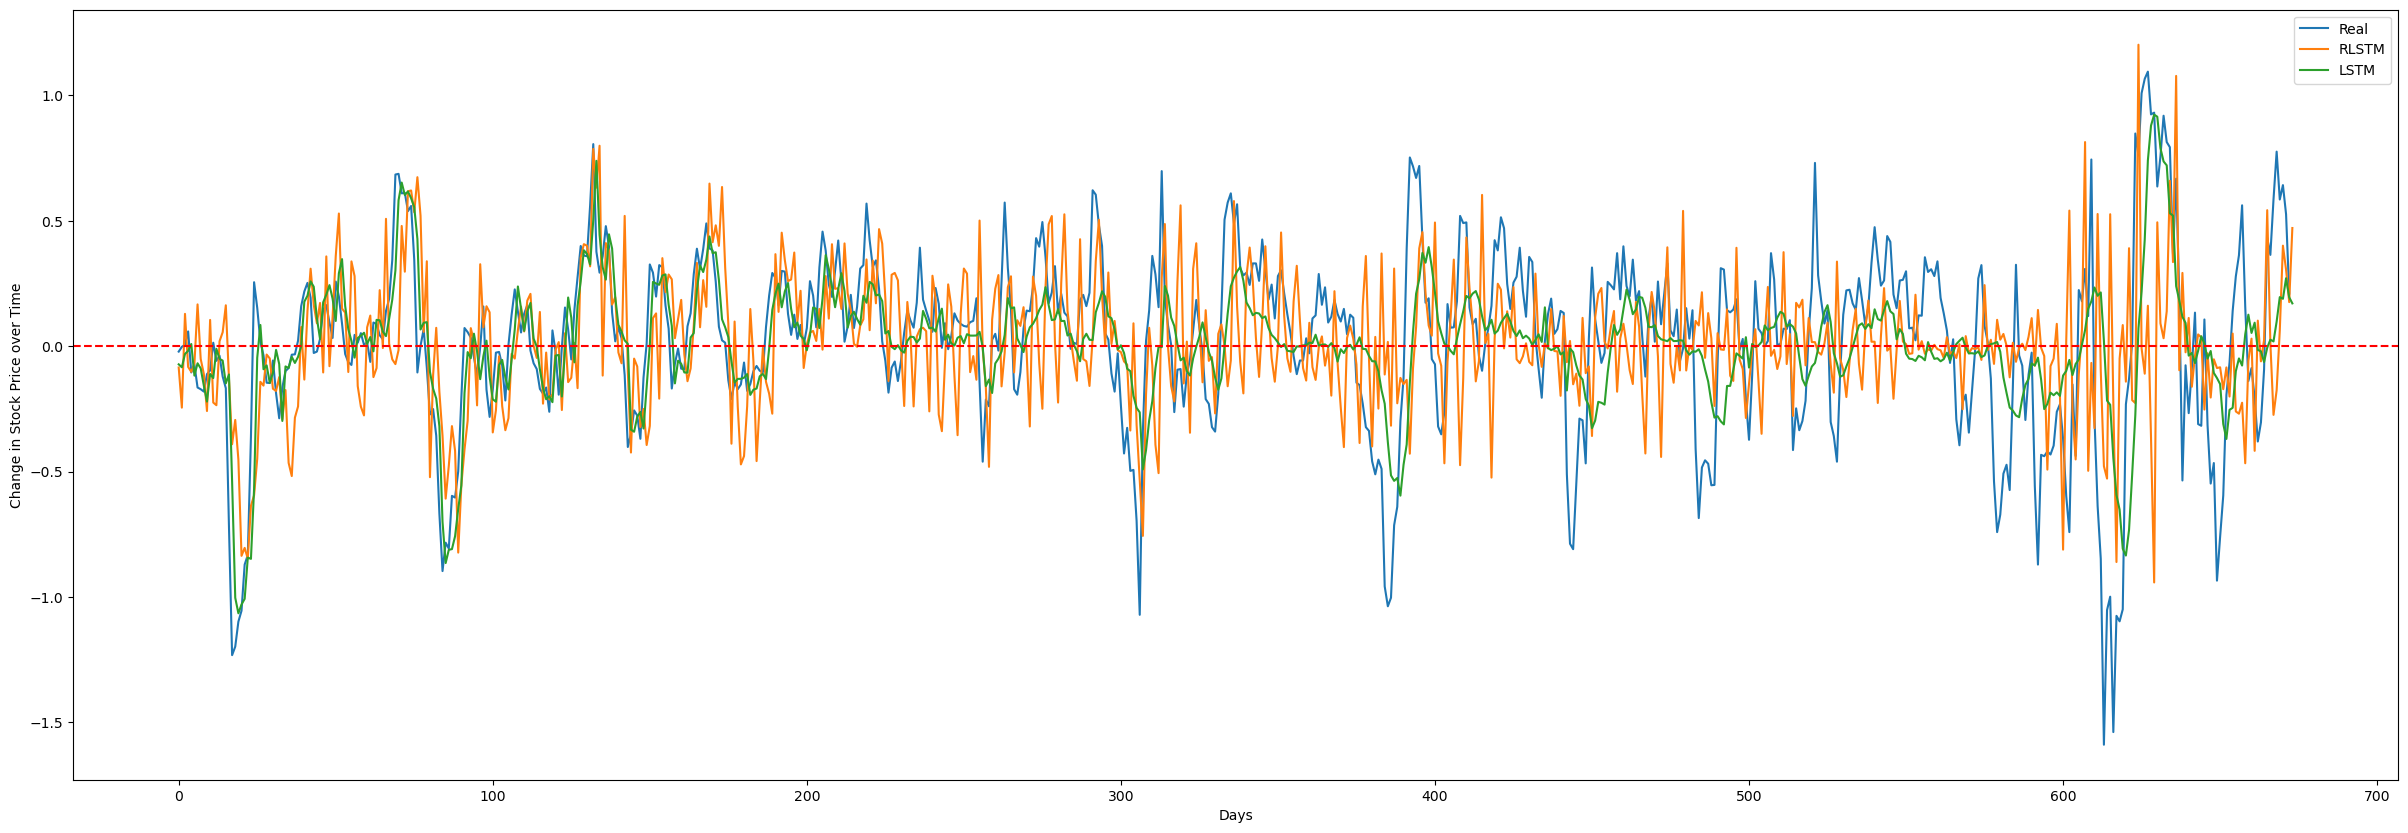

In [26]:
# Plotting the derivative of the outputs
from numpy import diff
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


y1 = df_out["RLSTM forecast"].iloc[size:].to_numpy()
y2 = df_out["LSTM forecast"].iloc[size:].to_numpy()
y3 = df["Close"].iloc[size:].to_numpy()

n = 7
y1 = moving_average(y1, n)
y2 = moving_average(y2, n)
y3 = moving_average(y3, n)

dy1 = diff(y1)/1
dy2 = diff(y2)/1
dy3 = diff(y3)/1

plt.figure(figsize=(30, 10))
plt.plot(dy3, label = "Real")
plt.plot(dy1, label = "RLSTM")
plt.plot(dy2, label = "LSTM")
plt.ylabel('Change in Stock Price over Time')
plt.xlabel('Days')
plt.axhline(y = 0, color = 'r', linestyle = 'dashed')    
plt.legend()
plt.show()


61.35674990680804
61.47628085714286


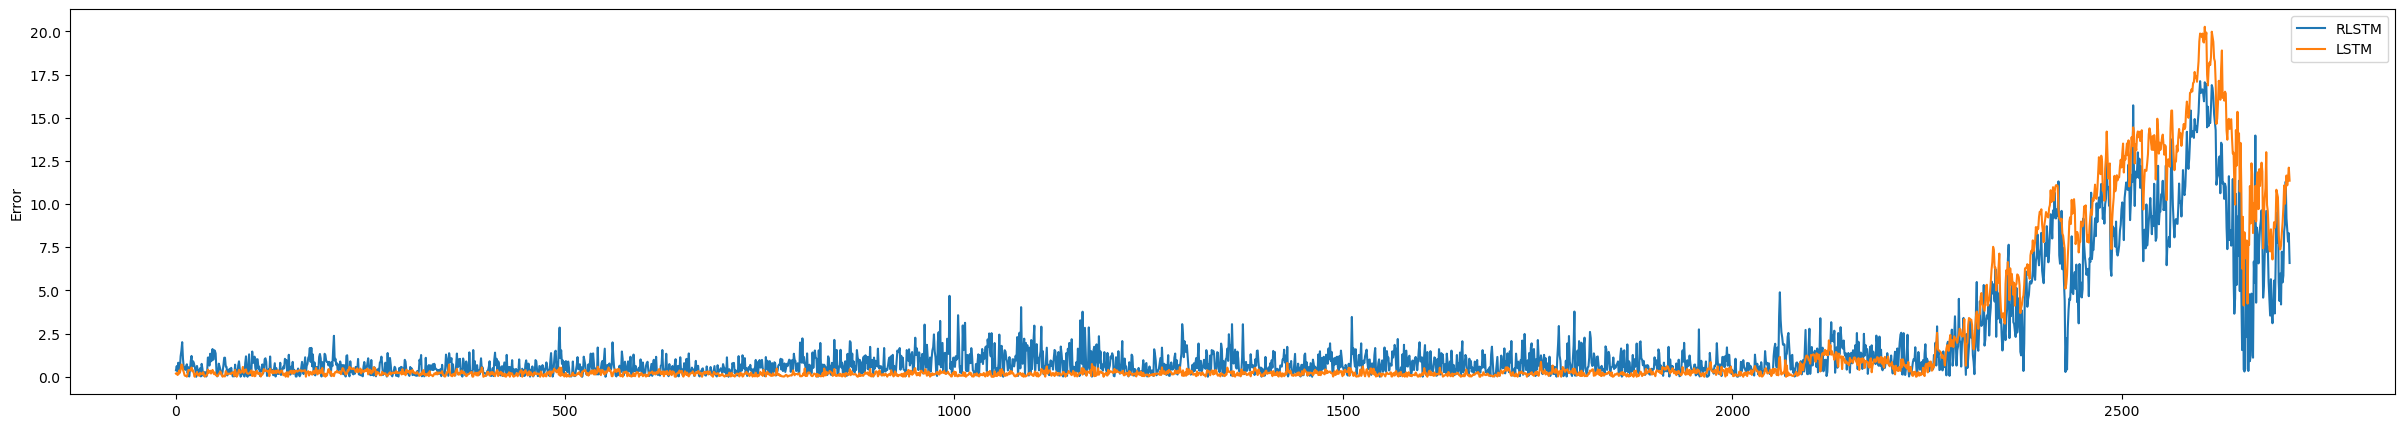

In [45]:
# Outputting the error of the models
error1 = abs(df_out["RLSTM forecast"]-df_out["Close"])
error2 = abs(df_out["LSTM forecast"]-df_out["Close"])
print(y1[2])
print(y3[2])

plt.figure(figsize=(30, 5))
plt.plot(error1, label = "RLSTM")
plt.plot(error2, label = "LSTM")
plt.ylabel('Error')
plt.legend()
plt.show()

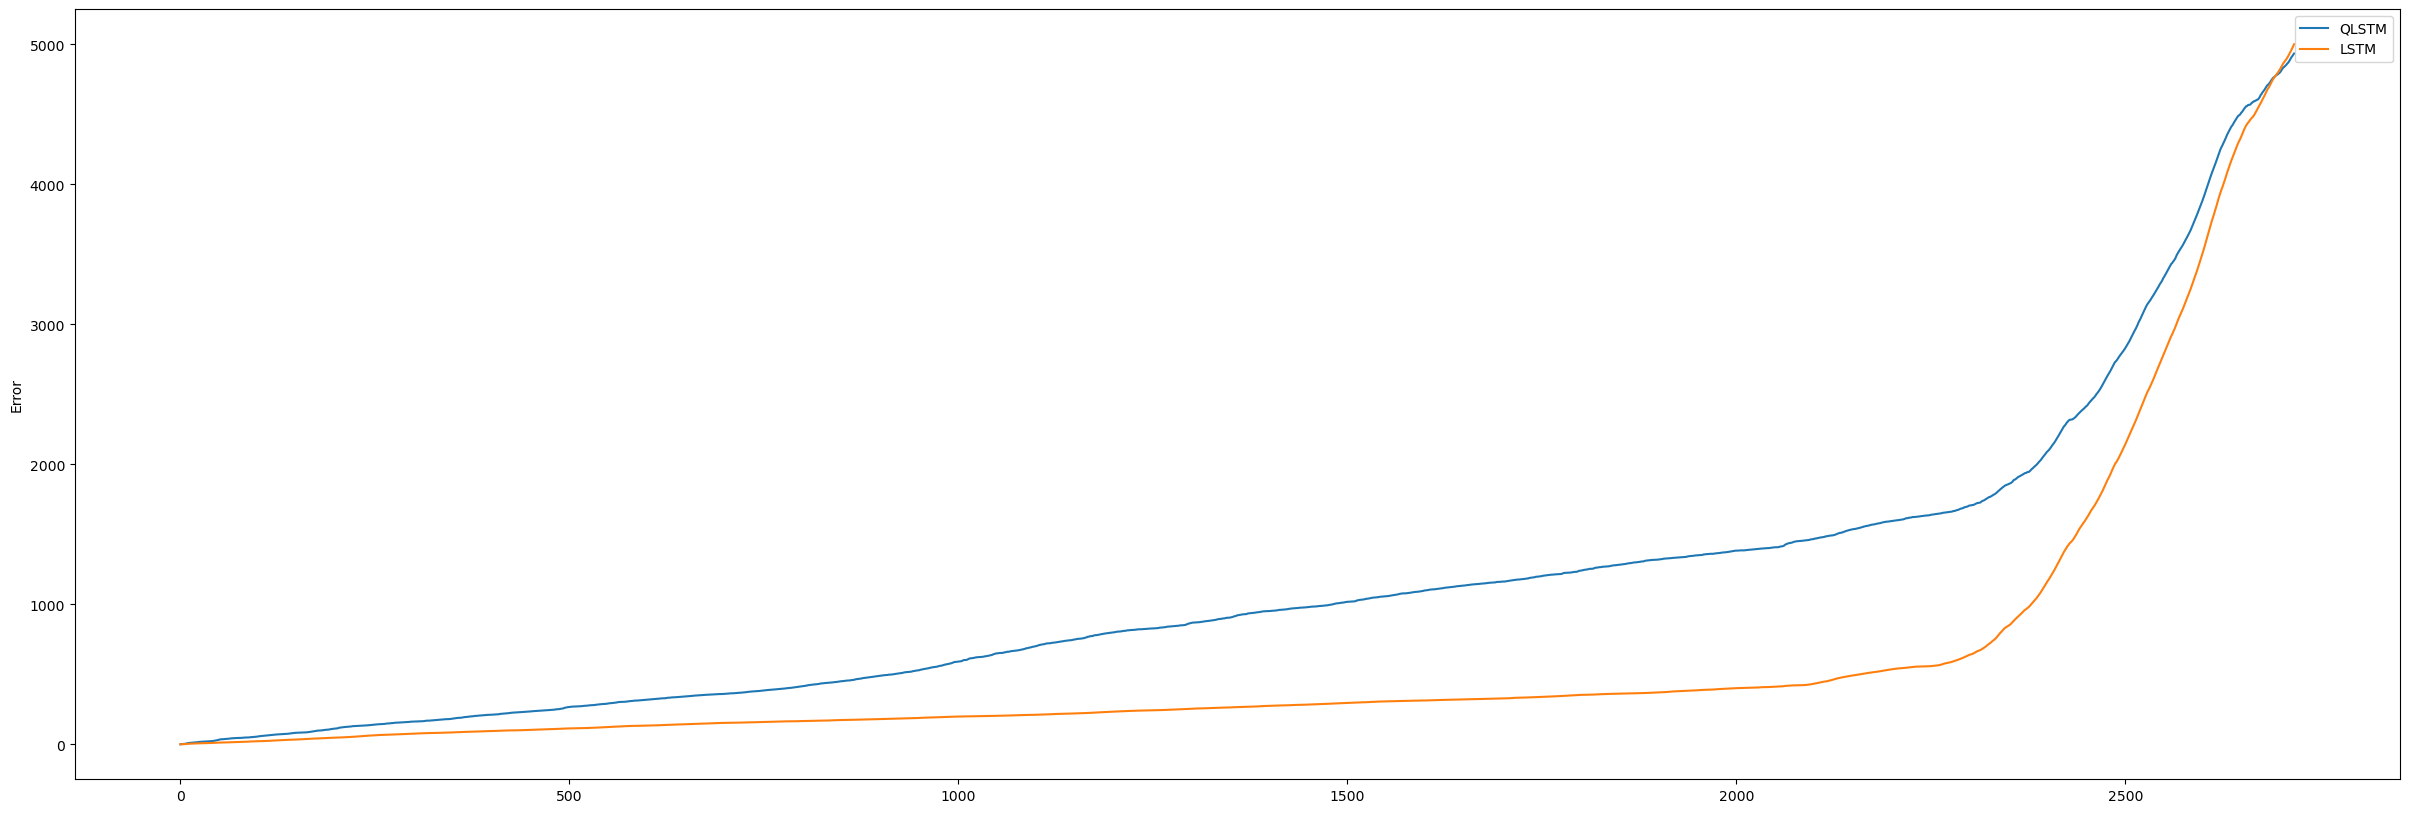

In [47]:
# Outputting the integration of the error across time 
from scipy import integrate
interr1 = np.zeros(shape=(len(error1)))
interr2 = np.zeros(shape=(len(error2)))

for i in range(len(error1)):
    x = np.arange(0, i+1)
    y1 = error1[0:i+1]
    y2 = error2[0:i+1]
    interr1[i] = integrate.simpson(y1, x)
    interr2[i] = integrate.simpson(y2, x)

plt.figure(figsize=(30, 10))
plt.plot(interr1, label = "QLSTM")
plt.plot(interr2, label = "LSTM")
plt.ylabel('Accumulation of Error')
plt.legend()
plt.show()

In [7]:
learning_rate = 0.005
num_hidden_units = 32

# Declare the models and their respective loss functions and optimizers for back porpogation
recall1 = RLSTM_Model(num_features=len(features), hidden_units=num_hidden_units, batch_size=batch_size, omega=96, num_recall=1)
recall2 = RLSTM_Model(num_features=len(features), hidden_units=num_hidden_units, batch_size=batch_size, omega=96, num_recall=2)
recall3 = RLSTM_Model(num_features=len(features), hidden_units=num_hidden_units, batch_size=batch_size, omega=96, num_recall=3)
recall4 = RLSTM_Model(num_features=len(features), hidden_units=num_hidden_units, batch_size=batch_size, omega=96, num_recall=4)

loss_function = nn.MSELoss()
optimizer1 = torch.optim.Adam(recall1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(recall2.parameters(), lr=learning_rate)
optimizer3 = torch.optim.Adam(recall3.parameters(), lr=learning_rate)
optimizer4 = torch.optim.Adam(recall4.parameters(), lr=learning_rate)

# Arrays for storing the losses outputted by the model
classical_loss_train1 = []
classical_loss_train2 = []
classical_loss_train3 = []
classical_loss_train4 = []
print("Untrained test\n--------")

# For loop that trains the model for a certain number of epochs
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss1 = train_RLSTM(train_loader, recall1, loss_function, optimizer=optimizer1)
    train_loss2 = train_RLSTM(train_loader, recall2, loss_function, optimizer=optimizer2)
    train_loss3 = train_RLSTM(train_loader, recall3, loss_function, optimizer=optimizer3)
    train_loss4 = train_RLSTM(train_loader, recall4, loss_function, optimizer=optimizer4)
    classical_loss_train1.append(train_loss1)
    classical_loss_train2.append(train_loss2)
    classical_loss_train1.append(train_loss3)
    classical_loss_train2.append(train_loss4)


Untrained test
--------
Epoch 0
---------
RLSTM Train loss: 0.9022860145196319


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x64 and 96x128)